In [102]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scanpy as sc
import decoupler as dc

from scipy.stats import pearsonr
from adjustText import adjust_text

from statsmodels.stats.multitest import fdrcorrection
from matplotlib.colors import LinearSegmentedColormap

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')  # low dpi (dots per inch) yields small inline figures

scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.23.5 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.1 pynndescent==0.5.4


In [2]:
%cd /home/orimosko/projects/phago/invivo

/home/orimosko/projects/phago/invivo


In [104]:
PHAGO_COLOR = "#FF97E2"
NONPHAGO_COLOR = "#00A86B"
PBS_COLOR = "#63A7FF"
RODOHIGH_COLOR = "#8A54A5"
GRAY = "#D3D3D3" 

In [4]:
plt.rcParams['pdf.fonttype'] = 42

In [5]:
os.environ['NUMEXPR_MAX_THREADS'] = '256'

In [6]:
adata = sc.read_h5ad("/mc_disk2/data/h5ads/phago/invivolung_qc.h5ad")

In [7]:
adata.shape

(6070, 16567)

In [8]:
adata.obs[['Batch.Set.ID', 'Cell_type']].value_counts(sort=False)

Batch.Set.ID  Cell_type          
Roi-IN1       PBS-injectedmyeloid     315
              non-phagomyeloid        642
              phagomyeloid            714
Roi-IN2       PBS-injectedmyeloid     364
              non-phagomyeloid        420
              phagomyeloid            822
Roi-IN3       PBS-injectedmyeloid     794
              non-phagomyeloid       1174
              phagomyeloid            825
Name: count, dtype: int64

In [9]:
adata.layers['counts'] = adata.X.copy()

In [10]:
adata.raw = adata

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [12]:
sc.pp.log1p(adata)

In [13]:
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [14]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [15]:
sum(adata.var.highly_variable)

2419

In [16]:
sc.pp.pca(adata, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [17]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [18]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [19]:
sc.tl.leiden(adata, resolution=1.5)

running Leiden clustering


    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


In [20]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [21]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"][0:25])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Fth1,Chil3,Chil3,Lpl,Fabp1,H2-Ab1,Car4,Ifitm3,Tuba1b,Car4,Chil3,Lyz2,H2-Ab1,Chil3,C1qb,Lcn2,Tmem123,Fth1,S100a8
1,Cstb,mt-Cytb,Cd9,Ear1,Ear1,H2-Aa,Chil3,Plac8,Tubb5,Lpl,Ear1,Fth1,H2-Eb1,Lyz2,C1qc,Il1rn,Crip1,Cstb,Stfa1
2,Lyz2,mt-Nd1,Ear2,Chil3,Chil3,H2-Eb1,Ccl6,Ly6e,Pcna,Ccl6,Lpl,Chil3,Cd74,Ear1,Cd74,Srgn,Cst3,Ftl1,S100a9
3,Ctsk,mt-Nd4,Ear1,Ear2,Ear2,Cd74,Fth1,Cst3,Chil3,Chil3,Ear2,Ctsk,H2-Aa,Ear2,C1qa,Clec4d,H2-K1,Ctsb,Cstdc5
4,Ccl6,mt-Rnr2,Atp6v0d2,Dusp1,Lpl,Cst3,Lyz2,Apoe,Stmn1,Clec7a,Lyz2,Cstb,Cst3,Ccl6,H2-Ab1,Ftl1,Fscn1,Ccl2,Stfa3
5,Ftl1,Lyz2,Ccl6,Ctsd,Lyz2,Plbd1,mt-Cytb,Cd52,Ptma,Plet1,mt-Nd4,Ftl1,S100a6,Atp6v0d2,H2-Aa,S100a8,Ccl22,Sod2,Cstdc4
6,Marco,Ear2,Lyz2,Abcg1,Cd9,Crip1,mt-Nd4,Ifi27l2a,Top2a,mt-Rnr2,mt-Cytb,Mt1,S100a4,Fth1,Tmem176b,Il1b,Cd74,Clec4e,Ngp
7,Lgals3,mt-Nd2,Fpr1,Cd9,mt-Rnr2,Naaa,Ftl1,B2m,Pclaf,Atp6v0d2,mt-Nd1,Ctsd,Plbd1,Ftl1,H2-Eb1,Ccl3,Ccr7,S100a6,Stfa2l1
8,Atp6v0d2,mt-Rnr1,Lpl,mt-Rnr1,Ctsd,Irf8,mt-Nd1,Lst1,Mki67,Ctsc,mt-Nd2,mt-Nd4,Crip1,Cd9,Apoe,S100a9,Tmem176b,Hmox1,Lcn2
9,Wfdc17,Fth1,Ctsd,Plet1,mt-Nd4,Gm2a,Atp6v0d2,S100a4,Hmgb2,mt-Nd1,mt-Rnr2,mt-Cytb,Cd52,mt-Cytb,Cst3,Malat1,S100a4,Fth1-ps,Camp


In [22]:
annot_list = ['AlvMacs', 'AlvMacs', 'AlvMacs', 'AlvMacs', 'AlvMacs', 
              'cDC1', 'AlvMacs', 'Monocytes', 'AlvMacs', 'AlvMacs', 
              'AlvMacs', 'AlvMacs', 'cDC2', 'AlvMacs', 
              'IntMacs', 'Neutrophils', 'Mreg DCs', 
              'Efferocytes', 'Young Neutrophils']

In [23]:
annot_order = ['AlvMacs', 'IntMacs', 'Monocytes', 'Efferocytes', 'cDC1', 'cDC2', 'Mreg DCs', 
               'Neutrophils', 'Young Neutrophils']

In [24]:
adata.obs['annots'] = pd.Categorical([annot_list[int(i)] for i in adata.obs.leiden], categories=annot_order, ordered=True)

In [25]:
adata.uns['Cell_type_colors'] = [PBS_COLOR, NONPHAGO_COLOR, PHAGO_COLOR]

/home/orimosko/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


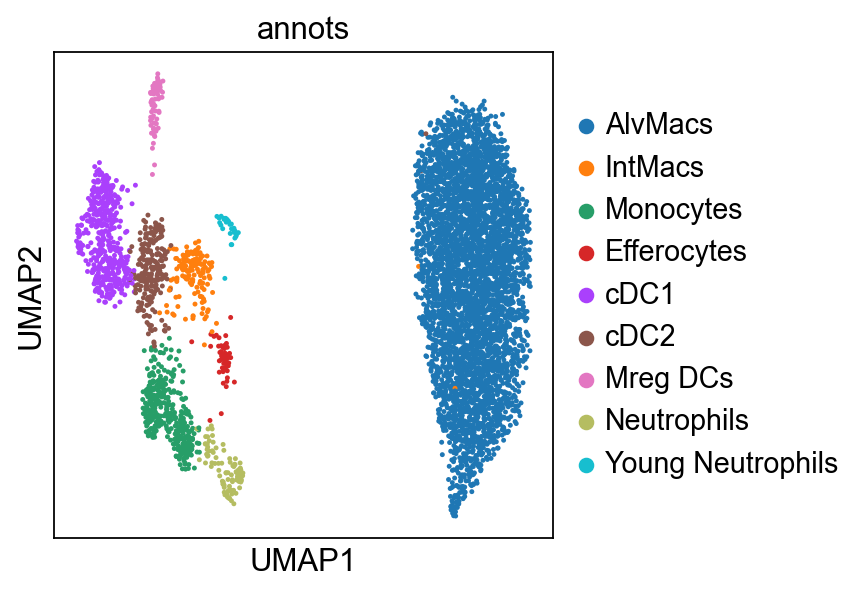

In [29]:
sc.pl.umap(adata, color=['annots'], save='_annots.pdf')

In [30]:
manual_genes = {'AlvMacs': ['Chil3', 'Ear1', 'Lpl', 'Mrc1', 'Cd164', 'Marco', 'Siglecf', 'Car4'],
                'IntMacs': ['Cd74', 'H2-Aa', 'H2-DMa', 'C1qb', 'Apoe'],
                'Monocytes': ['Csf1r', 'Ccr2', 'Plac8', 'Ifitm3', 'Ly6c2', 'Ms4a6b', 'Ms4a4c'],
                'Efferocytes': ['Hmox1', 'Spp1', 'Msr1', 'Arg1'],
                'cDC1': ['Xcr1', 'Irf8', 'Clec9a'],
                'cDC2': ['Cd209a', 'Tmem176a', 'Tmem176b'],
                'Mreg DCs': ['Fscn1', 'Ccl22', 'Ccl5', 'Ccr7'],
                'Neutrophils': ['S100a8', 'Il1b', 'Csf3r', 'Il36g', 'Retnlg'],
                'Young Neutrophils': ['Ngp', 'Camp', 'Stfa1', 'Cstdc5']}

/home/orimosko/.local/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


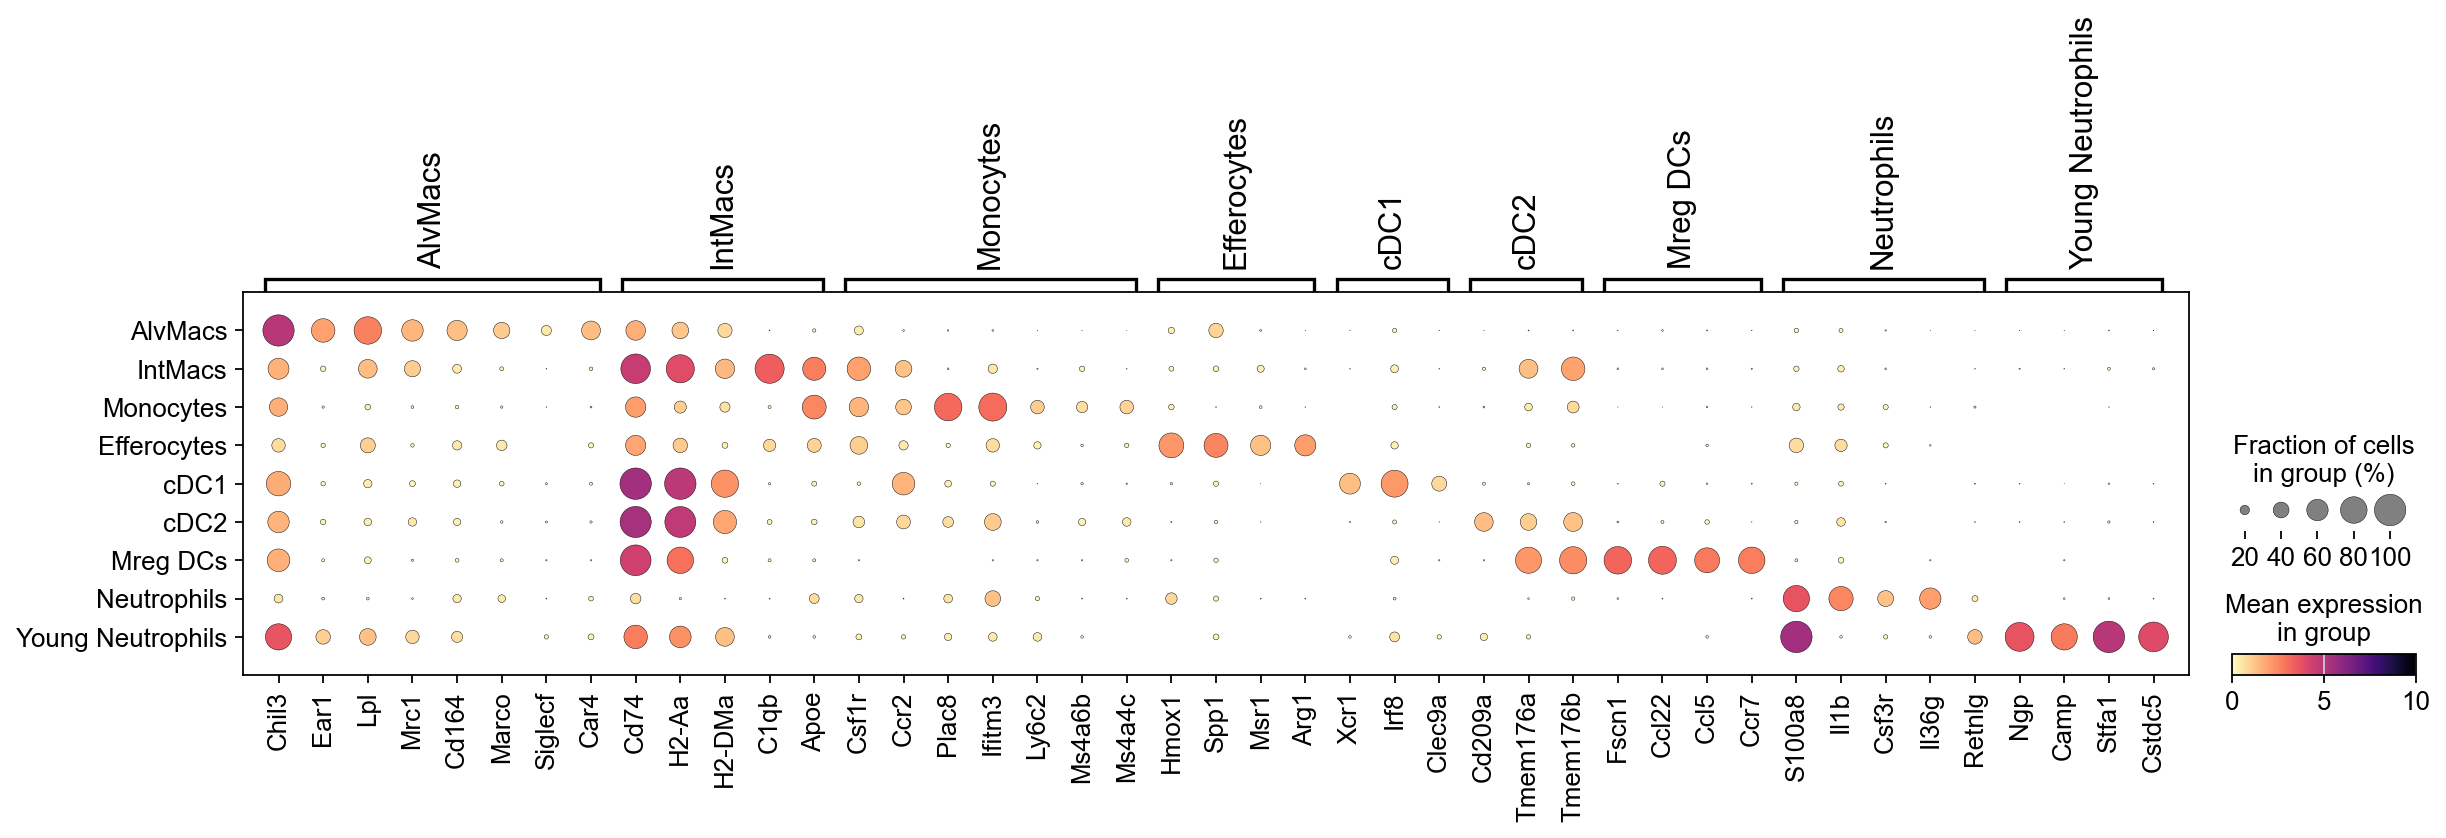

In [32]:
sc.pl.dotplot(adata, manual_genes, groupby="annots", cmap="magma_r", vmin=0, vmax=10, use_raw=False, save='annots.pdf')

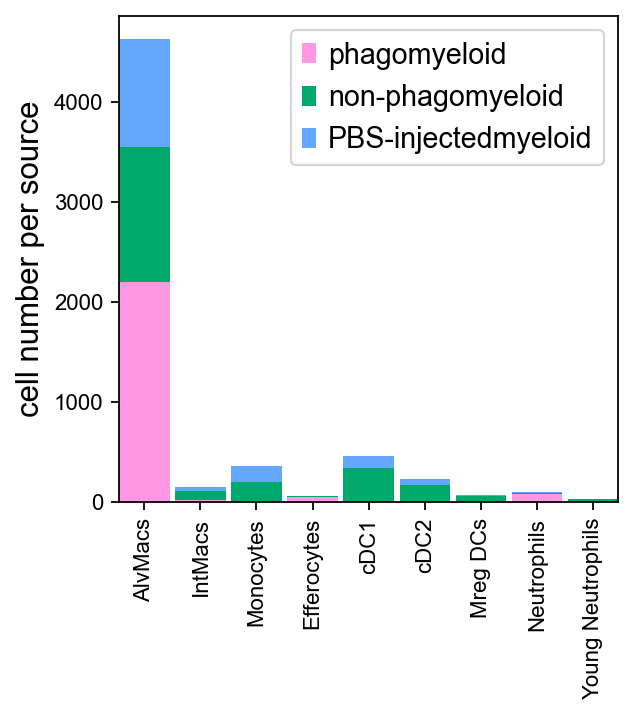

In [33]:
df = pd.DataFrame(index=adata.obs.annots.values.categories,
                  data=[adata[adata.obs.annots.values == i, :].obs.Cell_type.value_counts() 
                        for i in adata.obs.annots.values.categories])
df = df.loc[df.index]
ax = df.plot(kind="bar", stacked=True, ylabel="cluster", width=0.9, fontsize=10, color=[PHAGO_COLOR, NONPHAGO_COLOR, PBS_COLOR])
ax.set_ylabel("cell number per source")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.grid(False)
ax.set_xlim((-0.45, len(df)-0.55))
#for col in df.columns[:-1]:
#    ax.vlines(100 * sum(adata.obs.Cell_type == col) / len(adata.obs), 
#              ymin=-0.45, ymax=len(df)-0.55, colors="black")
plt.savefig("figures/composition_barplot_absolute.pdf", bbox_inches="tight")

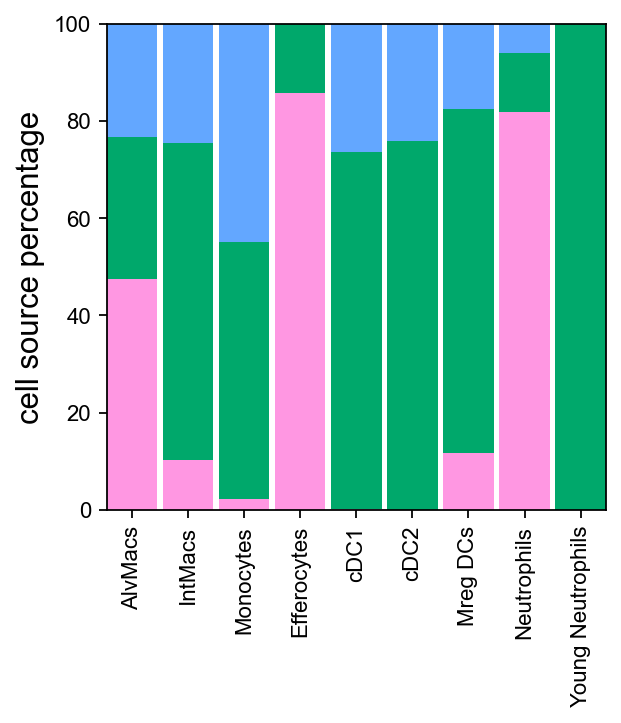

In [34]:
df = pd.DataFrame(index=adata.obs.annots.values.categories,
                  data=[adata[adata.obs.annots.values == i, :].obs.Cell_type.value_counts() 
                        for i in adata.obs.annots.values.categories])
for i in df.index:
    df.loc[i] = 100 * df.loc[i] / np.nansum(df.loc[i])
ax = df.plot(kind="bar", stacked=True, ylabel="cluster", width=0.9, color=[PHAGO_COLOR, NONPHAGO_COLOR, PBS_COLOR], fontsize=10)
ax.set_ylabel("cell source percentage")
ax.get_legend().remove()  # Remove the legend
ax.grid(False)
ax.set_ylim((0,100))
ax.set_xlim((-0.45, len(df)-0.55))

#for col in df.columns[:-1]:
#    ax.vlines(100 * sum(adata.obs.Cell_type == col) / len(adata.obs), 
#              ymin=-0.45, ymax=len(df)-0.55, colors="black")
plt.savefig("figures/composition_barplot.pdf", bbox_inches="tight")

# AlvMac differential gene expression 

In [37]:
full_adata = adata.copy()

In [50]:
adata = full_adata[full_adata.obs.annots == "AlvMacs"]

In [51]:
adata.shape

(4630, 16567)

In [52]:
sc.pp.filter_genes(adata, min_cells=100)

filtered out 10681 genes that are detected in less than 100 cells


/home/orimosko/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [53]:
bad_genes = adata.var_names[(adata.var_names.str.startswith('mt-') |
                             adata.var_names.str.startswith('Gm') |
                             adata.var_names.str.startswith('Rps') |
                             adata.var_names.str.startswith('Rpl') |
                             adata.var_names.str.contains('-ps') |
                             adata.var_names.str.endswith('Rik') |
                             adata.var_names.str.endswith('Rik2') |
                             adata.var_names.str.endswith('Rik8')
                            )]

In [54]:
bad_genes = bad_genes.tolist() + ['Rn18s-rs5']

In [55]:
adata = adata[:, ~adata.var_names.isin(bad_genes)]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/tmp/ipykernel_2605686/1519949237.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcano_df.pvals_adj[volcano_df.pvals_adj < 1e-20] = 1e-20
/tmp/ipykernel_2605686/1519949237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcano_df.logfoldchanges[volcano_df.logfoldchanges < -2] = -2
/tmp/ipykernel_2605686/1519949237.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcano_df.logfoldchanges[volcano_df.logfoldchanges > 2] = 

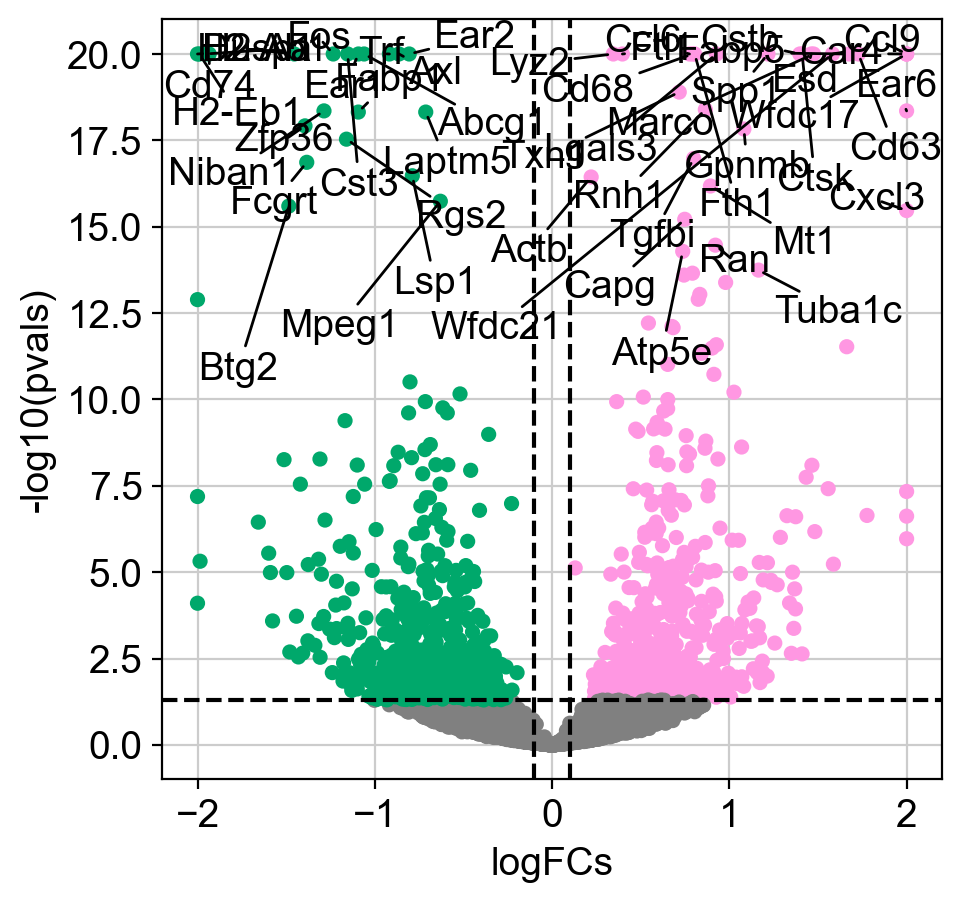

In [58]:
sc.tl.rank_genes_groups(adata, groupby='Cell_type', groups=['phagomyeloid'], reference='non-phagomyeloid', pts=True, use_raw=False)
phago_vs_non = sc.get.rank_genes_groups_df(adata, 'phagomyeloid').set_index('names')
phago_vs_non.to_excel('tables/phago_vs_non.xlsx')

volcano_df = phago_vs_non.copy()

volcano_df.pvals_adj[volcano_df.pvals_adj < 1e-20] = 1e-20
volcano_df.logfoldchanges[volcano_df.logfoldchanges < -2] = -2
volcano_df.logfoldchanges[volcano_df.logfoldchanges > 2] = 2

dc.plot_volcano_df(
    volcano_df,
    x='logfoldchanges',
    y='pvals_adj',
    top=50,
    sign_thr=0.05,
    lFCs_thr=0.1,
    figsize=(5, 5),
    color_pos=PHAGO_COLOR,
    color_neg=NONPHAGO_COLOR,
    #save="./figures/volcano.pdf"
)
plt.savefig('figures/invivo_volcano_phago_vs_non.pdf')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/tmp/ipykernel_2605686/2506202532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcano_df.pvals_adj[volcano_df.pvals_adj < 1e-20] = 1e-20
/tmp/ipykernel_2605686/2506202532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcano_df.logfoldchanges[volcano_df.logfoldchanges < -2] = -2
/tmp/ipykernel_2605686/2506202532.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volcano_df.logfoldchanges[volcano_df.logfoldchanges > 2] = 

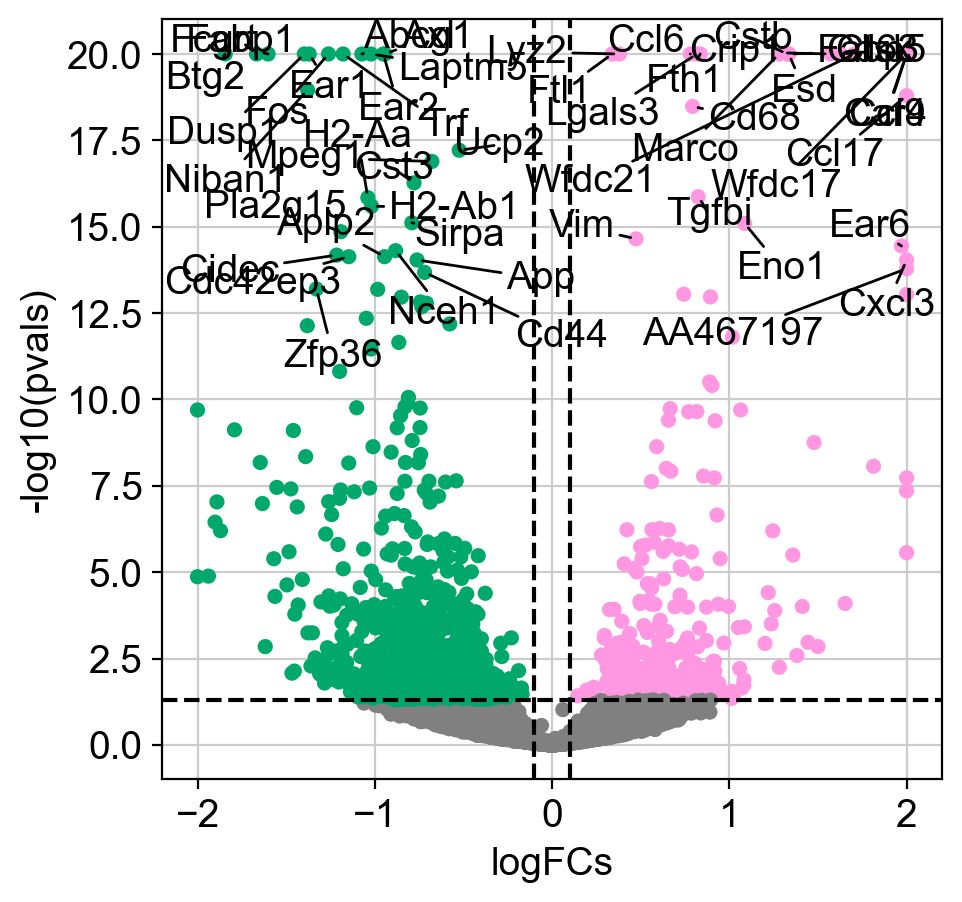

In [59]:
sc.tl.rank_genes_groups(adata, groupby='Cell_type', groups=['phagomyeloid'], reference='PBS-injectedmyeloid', pts=True, use_raw=False)
phago_vs_pbs = sc.get.rank_genes_groups_df(adata, 'phagomyeloid').set_index('names')
phago_vs_pbs.to_excel('tables/phago_vs_pbs.xlsx')

volcano_df = phago_vs_pbs.copy()

volcano_df.pvals_adj[volcano_df.pvals_adj < 1e-20] = 1e-20
volcano_df.logfoldchanges[volcano_df.logfoldchanges < -2] = -2
volcano_df.logfoldchanges[volcano_df.logfoldchanges > 2] = 2

dc.plot_volcano_df(
    volcano_df,
    x='logfoldchanges',
    y='pvals_adj',
    top=50,
    sign_thr=0.05,
    lFCs_thr=0.1,
    figsize=(5, 5),
    color_pos=PHAGO_COLOR,
    color_neg=NONPHAGO_COLOR,
    #save="./figures/volcano.pdf"
)
plt.savefig('figures/invivo_volcano_phago_vs_pbs.pdf')

In [60]:
phago_vs_non.columns = [c + "_phago_vs_non" for c in phago_vs_non.columns]

In [61]:
phago_vs_pbs.columns = [c + "_phago_vs_pbs" for c in phago_vs_pbs.columns]

In [62]:
merged = pd.concat([phago_vs_non, phago_vs_pbs], axis=1)

In [64]:
merged = merged[~(merged.index.str.startswith('Gm') | merged.index.str.startswith('Rp') | 
                  merged.index.str.startswith('mt-') | merged.index.str.contains('-ps'))]

In [68]:
cond_arr = (((merged.pvals_adj_phago_vs_non < 0.05) & (merged.logfoldchanges_phago_vs_non > 1)) &
            ((merged.pvals_adj_phago_vs_pbs < 0.05) & (merged.logfoldchanges_phago_vs_pbs > 1)))

In [69]:
sum(cond_arr)

25

In [70]:
upregulated = aa = merged.index[cond_arr]

In [71]:
upregulated

Index(['Wfdc17', 'Car4', 'Ccl9', 'Fabp5', 'Wfdc21', 'Cstb', 'Marco', 'Ctsk',
       'Cd63', 'Esd', 'Ear6', 'Cxcl3', 'Ch25h', 'Clec4d', 'Tyms', 'AA467197',
       'Anpep', 'Clec4e', 'Ccl17', 'Pdpn', 'Sdf2l1', 'Basp1', 'Psat1', 'Lcn2',
       'Mecr'],
      dtype='object', name='names')

In [72]:
gene_df = adata[:,upregulated].to_df()

In [73]:
gene_df['batch_type'] = adata.obs['Batch.Set.ID'].astype(str) + "_" + adata.obs.Cell_type.astype(str)

In [74]:
gene_df = gene_df.groupby('batch_type').mean()

In [75]:
gene_df = (gene_df - gene_df.mean()) / gene_df.std()

In [76]:
sns.set_style("white", {"axes.grid": False})

In [77]:
gene_df.index = gene_df.index.str.replace('Roi-IN','').str.replace('-injectedmyeloid','').str.replace('phagomyeloid', 'effero')

In [78]:
gene_df = gene_df.loc[['1_effero', '2_effero', '3_effero', '1_non-effero', '2_non-effero', '3_non-effero', '1_PBS', '2_PBS', '3_PBS']]

[Text(1, 0.5, '1_effero'),
 Text(1, 1.5, '2_effero'),
 Text(1, 2.5, '3_effero'),
 Text(1, 3.5, '1_non-effero'),
 Text(1, 4.5, '2_non-effero'),
 Text(1, 5.5, '3_non-effero'),
 Text(1, 6.5, '1_PBS'),
 Text(1, 7.5, '2_PBS'),
 Text(1, 8.5, '3_PBS')]

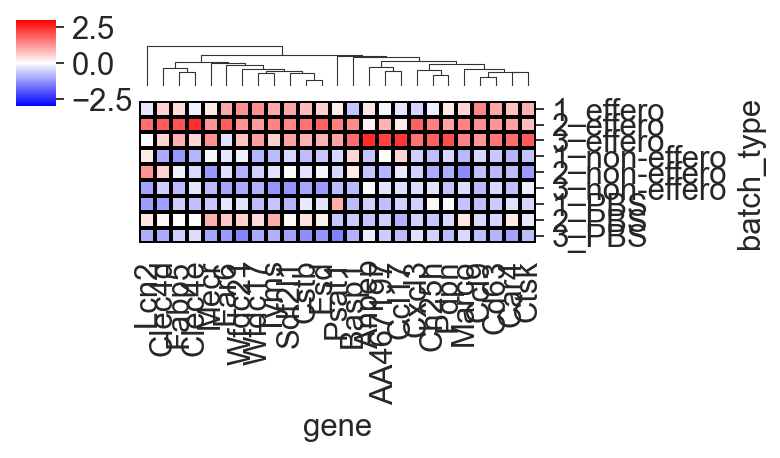

In [ ]:
#plt.figure(figsize=(2,1))
g = sns.clustermap(gene_df, cmap='bwr', xticklabels=True, center=0, vmin=-3, vmax=3, 
                   yticklabels=True, row_cluster=False, linewidths=1, linecolor='black', figsize=(5,3))
# Make each tile square
g.ax_heatmap.set_aspect("equal")
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('figures/scaled_hm_upregulated.pdf')

In [81]:
plot_genes = merged[(merged.logfoldchanges_phago_vs_non > 2) | (merged.logfoldchanges_phago_vs_pbs > 2)  | 
                    (merged.logfoldchanges_phago_vs_non < -2)].index

In [82]:
plot_genes

Index(['Wfdc17', 'Car4', 'Ccl9', 'Cd63', 'Ear6', 'Cxcl3', 'Clec4d', 'Pilrb1',
       'AA467197', 'Anpep', 'Msr1', 'Ccl17', 'Lcn2', 'Colec12', 'Abca1',
       'Nr4a1', 'Apoe', 'H2-Aa'],
      dtype='object', name='names')

155

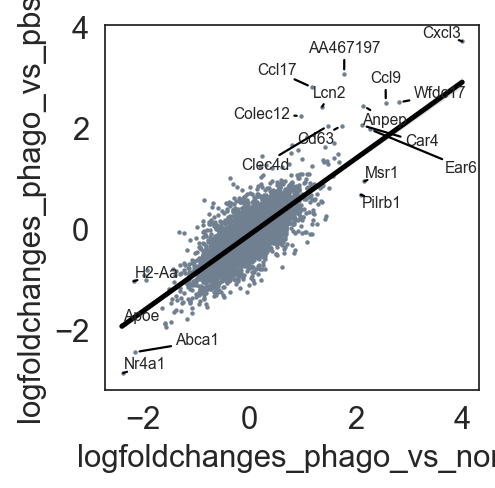

In [ ]:
plt.figure(figsize=(3,3))
sns.regplot(merged, x='logfoldchanges_phago_vs_non', y='logfoldchanges_phago_vs_pbs', 
            scatter_kws={'color': 'slategray', 'alpha':1, 's':1},
            line_kws={'color': 'black'})
texts = [plt.text(y=merged.loc[pl, 'logfoldchanges_phago_vs_pbs'], 
                  x=merged.loc[pl, 'logfoldchanges_phago_vs_non'], s=pl, fontsize=7) 
         for pl in plot_genes]
adjust_text(texts, expand_text=(1.2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='black')) # ensure the labeling is clear by adding arrows
#plt.hlines()
#plt.xlim(-5, 3)
#plt.ylim(-5, 3)
plt.savefig('figures/correlation.pdf')

In [87]:
r, p = pearsonr(merged.logfoldchanges_phago_vs_non, merged.logfoldchanges_phago_vs_pbs)
print("R",r)
print("P",p)


R 0.7645473319326337
P 0.0


# pHrodo correlation

In [88]:
cdata = adata[adata.obs.Cell_type == "phagomyeloid"]

In [89]:
cell_dict = {}
for ab in cdata.obs["Amp.Batch.ID"].unique():
    try:
        index_df = pd.read_csv("annotations/" + ab + "_index.csv", skiprows=15)[['Well', 'All Events YG 582/15-A Mean']]
    except FileNotFoundError:
        index_df = pd.read_csv("index_data/" + ab + "_index.csv", skiprows=9)[['well', '*YG 586/15 - 570LP-A']]
    for well, facs_index in index_df.values:
        cell_dict[ab + "_" + well] = facs_index

In [90]:
ab_sb = cdata.obs[['Amp.Batch.ID', 'Batch.Set.ID']].drop_duplicates().set_index('Amp.Batch.ID').to_dict()['Batch.Set.ID']

In [91]:
cdata = cdata[np.intersect1d(cdata.obs_names, list(cell_dict.keys()))]

In [92]:
scaled_index = pd.DataFrame({'cell': cell_dict.keys(),
                             "batch": [ab_sb[ab.split("_")[0]] for ab in cell_dict.keys()],
                             "FACS_index": cell_dict.values()}).set_index('cell')
scaled_index = scaled_index[scaled_index.index.isin(cdata.obs_names)]
scaled_index['FACS_index'] = [float(str(x).replace(",", "")) for x in scaled_index['FACS_index']]

scaled_index['log_FACS_index'] = np.log(scaled_index['FACS_index'])
scaled_index['scaled_index'] = scaled_index.groupby('batch')['log_FACS_index'].transform(lambda x: (x - x.mean()) / x.std())

In [93]:
scaled_index = scaled_index.loc[cdata.obs_names]

In [94]:
cdata.obs = pd.concat([cdata.obs, scaled_index], axis=1)

In [96]:
cond_arr = (((merged.pvals_adj_phago_vs_non < 0.05) & (merged.logfoldchanges_phago_vs_non > 0)) &
            ((merged.pvals_adj_phago_vs_pbs < 0.05) & (merged.logfoldchanges_phago_vs_pbs > 0)))

In [97]:
sum(cond_arr)

242

In [98]:
upregulated = aa = merged.index[cond_arr]

In [99]:
cdata.obs['upregulated_sum'] = 10000 * cdata[:,upregulated].layers['counts'].sum(axis=1).A1 / cdata.obs.total_counts

In [100]:
sc.tl.score_genes(cdata, upregulated, score_name='upregulated_over0')

computing score 'upregulated_over0'
    finished: added
    'upregulated_over0', score of gene set (adata.obs).
    339 total control genes are used. (0:00:00)


In [105]:

custom_cmap = LinearSegmentedColormap.from_list('rodo_scale', [GRAY, PHAGO_COLOR, RODOHIGH_COLOR])

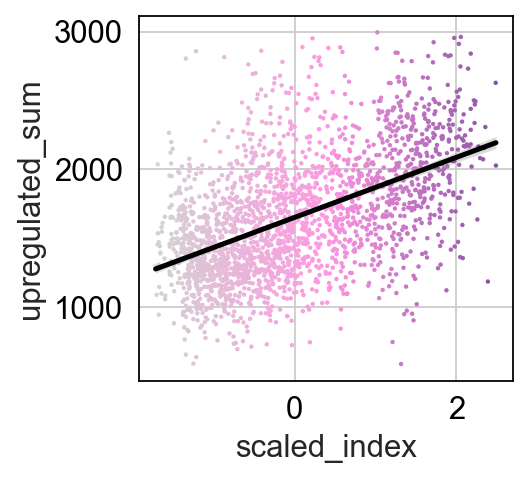

In [107]:
plt.figure(figsize=(3,3))

# Scatter plot
plt.scatter(cdata.obs['scaled_index'], cdata.obs['upregulated_sum'],
            alpha=1, s=1, c=cdata.obs['scaled_index'], cmap=custom_cmap)

# Regression line
sns.regplot(data=cdata.obs, x='scaled_index', y='upregulated_sum',
            scatter=False, line_kws={'color': 'black'})

plt.savefig('figures/index_corr_sum.pdf')

In [108]:
r, p = pearsonr(cdata.obs['scaled_index'], cdata.obs['upregulated_sum'])
print("R",r)
print("P",p)

R 0.5057278401482825
P 4.645707521332613e-143


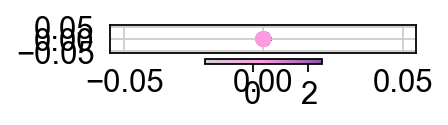

In [109]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(3, 1))

# Scatter plot with cdata.obs['scaled_index'] as color values
scatter = ax.scatter([0] * len(cdata.obs['scaled_index']),  # Dummy y-values
                     [0] * len(cdata.obs['scaled_index']),  # Dummy x-values
                     c=cdata.obs['scaled_index'],
                     cmap=custom_cmap)

# Create the colorbar/legend
legend = fig.colorbar(scatter, ax=ax, orientation='horizontal')
plt.tight_layout()
plt.savefig('figures/rodo_scale_legend_scaled_index.pdf')
plt.show()


In [110]:
cdata.X = cdata.X.todense()
gene_df = pd.DataFrame(index=cdata.var_names,
                       columns=['pearson_R', 'p_value'])
for g in gene_df.index:
    gene_df.loc[g] = pearsonr(cdata.obs.scaled_index, cdata[:,g].X.flatten())

In [111]:
gene_df['p_val_corr'] = fdrcorrection(gene_df.p_value)[1]

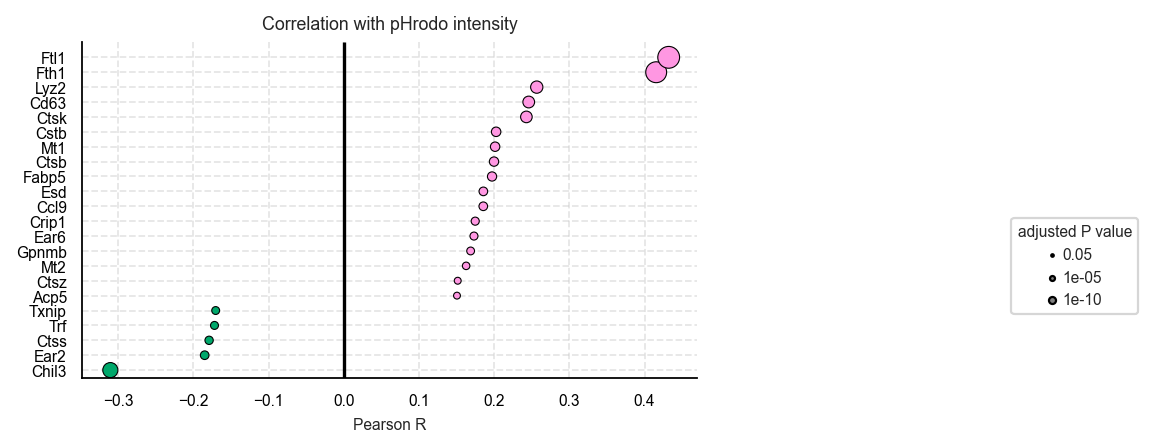

In [113]:
# Compute -log10(adj_pval) for size mapping
gene_df["neg_log10_adj_pval"] = -np.log10(gene_df["p_val_corr"].astype(float))

plogene_df = gene_df[(gene_df.p_val_corr < 0.001) & (gene_df.pearson_R.abs() > 0.15)].sort_values(by='pearson_R').reset_index(names='names')

mm = 0.1/2.54

plt.rcParams.update({
    'font.size': 7,         # Default font size
    'axes.labelsize': 7,    # X and Y axis labels
    'axes.titlesize': 7,    # Title
    'xtick.labelsize': 7,   # X-axis tick labels
    'ytick.labelsize': 7,   # Y-axis tick labels
    'legend.fontsize': 7,   # Legend text
    'figure.titlesize': 7   # Figure title
})


# Create figure
fig, ax = plt.subplots(figsize=(125*mm, 70*mm))
plt.rcParams.update({'font.size': 7})

# Scatter plot with manually mapped colors
scatter = ax.scatter(
    plogene_df['pearson_R'], plogene_df['names'],
    c=[NONPHAGO_COLOR if i < 0 else PHAGO_COLOR for i in plogene_df['pearson_R']],
    s=plogene_df['neg_log10_adj_pval'], edgecolor='black', linewidths=0.5,
)

# Labels and title
ax.set_xlabel("Pearson R", fontdict={'size': 7})
ax.set_ylabel("")
ax.set_title("Correlation with pHrodo intensity", fontdict={'size': 8})
plt.vlines(0, -1, len(plogene_df), color='black')
ax.set_ylim(-0.5, len(plogene_df))

size_legend_values = np.array([0.05, 1e-5, 1e-10])  # Example p-values
size_legend_sizes = -np.log10(size_legend_values)  # Convert to plot sizes

legend_handles = [plt.scatter([], [], s=size, edgecolor='black', color='gray', label=pval)
                  for size, pval in zip(size_legend_sizes, size_legend_values)]

plt.legend(handles=legend_handles, title="adjusted P value", loc='upper left', bbox_to_anchor=(1.5, 0.5))

# Grid for readability
ax.grid(True, linestyle="--", alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.savefig('figures/index_corr_dotplot.pdf')


In [116]:
merged = pd.concat([phago_vs_non, phago_vs_pbs], axis=1)

In [119]:
merged.sort_index(inplace=True)

In [123]:
merged = merged[[col for col in merged.columns if not 'nz' in col]]

In [127]:
gene_df.columns = ["pHrodo " + col for col in gene_df.columns]

In [128]:
gene_df = gene_df[gene_df.columns[:-1]]

In [131]:
final_merged = pd.merge(merged, gene_df, left_index=True, right_index=True)

In [ ]:
#Effero score:
final_merged[(final_merged.pvals_adj_phago_vs_non < 0.05) & (final_merged.logfoldchanges_phago_vs_non > 0) &
             (final_merged['pHrodo p_val_corr'] < 0.05) & (final_merged['pHrodo pearson_R'] > 0)].index.tolist()

['Acp5',
 'Aldoa',
 'Anpep',
 'Anxa4',
 'Anxa5',
 'Atp5k',
 'Atp5mpl',
 'Atp6v0b',
 'Atp6v1c1',
 'Bcap31',
 'Calm1',
 'Calm3',
 'Calr',
 'Capg',
 'Cav1',
 'Ccl17',
 'Ccl9',
 'Cd24a',
 'Cd63',
 'Cd68',
 'Clec4d',
 'Crip1',
 'Cstb',
 'Ctsb',
 'Ctsk',
 'Ctsz',
 'Cyba',
 'Ear6',
 'Emp3',
 'Eno1b',
 'Esd',
 'Fabp4',
 'Fabp5',
 'Fth1',
 'Ftl1',
 'Gapdh',
 'Gla',
 'Glrx',
 'Gpnmb',
 'Hint1',
 'Lgals1',
 'Lgals3',
 'Lyz2',
 'Manf',
 'Marco',
 'Mfge8',
 'Mrpl52',
 'Msr1',
 'Mt1',
 'Mt2',
 'Nme1',
 'Nqo2',
 'Prdx1',
 'Pycard',
 'Rnh1',
 'Slc39a2',
 'Sod2',
 'Tceal9',
 'Timm13',
 'Tmsb10',
 'Tspo',
 'Tuba1c',
 'Tyms',
 'Vat1',
 'Wfdc17']

In [137]:
final_merged.to_excel('tables/Supp3.xlsx')